This notebook Analyzes the distribution of the sentiments and maps the sentiments "Ambiguous" and "Neutral" to Positive/Negative. Mantaining the true neutral ones.

After that :

- Tests every Vetorization technique with plenty of different models.

- Aplies smote to see if there is any good change.

- Grid search for hyperparameter tuning.




In [42]:
import os
import numpy as np
import pandas as pd
from scipy.sparse import load_npz


# Load your features and labels
features_dir = 'features'
X_tfidf = load_npz(os.path.join(features_dir, 'tfidf_features.npz'))
X_bow = load_npz(os.path.join(features_dir, 'bow_features.npz'))  # Add this line for Bag of Words
X_embeddings = np.load(os.path.join(features_dir, 'embedding_features.npy'))  
X_tfidf_embeddings = np.load(os.path.join(features_dir, 'tfidf_embedding_features.npy'))
labels_df = pd.read_csv(os.path.join(features_dir, 'emotionverse_labels.csv'))


In [43]:
print(labels_df["sentiment"].value_counts())


sentiment
Mixed        652
Positive     542
Negative     419
Ambiguous    158
Neutral      103
Name: count, dtype: int64


In [ ]:

# Count occurrences of each primary_emotion in Positive & Negative
positive_negative_counts = labels_df[labels_df["sentiment"].isin(["Positive", "Negative"])] \
    .groupby(["sentiment", "primary_emotion"]).size().unstack(fill_value=0)

# Define a function to transform sentiment
def transform_sentiment(row):
    if row["sentiment"] in ["Ambiguous", "Neutral"]:
        emotion = row["primary_emotion"]
        pos_count = positive_negative_counts.loc["Positive", emotion] if emotion in positive_negative_counts.columns else 0
        neg_count = positive_negative_counts.loc["Negative", emotion] if emotion in positive_negative_counts.columns else 0
        
        # Assign to the more frequent sentiment
        if pos_count > neg_count:
            return "Positive"
        elif neg_count > pos_count:
            return "Negative"
        else:
            return "Neutral"  # If no clear mapping, keep it as Neutral
    return row["sentiment"]

# Apply transformation
labels_df["sentiment"] = labels_df.apply(transform_sentiment, axis=1)

# Save transformed dataset
labels_df.to_csv("transformed_emotionverse_labels.csv", index=False)

# Display class distribution after transformation
print(labels_df["sentiment"].value_counts())


sentiment
Mixed       652
Positive    596
Negative    537
Neutral      89
Name: count, dtype: int64


c:\Users\Rafa Parkoureiro\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rafa Parkoureiro\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rafa Parkoureiro\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()


----- Overall Model Comparison -----
                                               Model  Accuracy  \
4                 Bag of Words - Logistic Regression  0.773333   
2                                TF-IDF - Linear SVM  0.757333   
1                       TF-IDF - Logistic Regression  0.749333   
3                         Bag of Words - Naive Bayes  0.722667   
5                          Bag of Words - Linear SVM  0.722667   
0                               TF-IDF - Naive Bayes  0.685333   
7                         Embeddings - Random Forest  0.640000   
10        TF-IDF Weighted Embeddings - Random Forest  0.618667   
9   TF-IDF Weighted Embeddings - Logistic Regression  0.576000   
6                   Embeddings - Logistic Regression  0.565333   
8                            Embeddings - Linear SVM  0.565333   
11           TF-IDF Weighted Embeddings - Linear SVM  0.562667   

    F1 Score (weighted)  
4              0.773715  
2              0.757562  
1              0.745484  

<Figure size 1200x800 with 0 Axes>

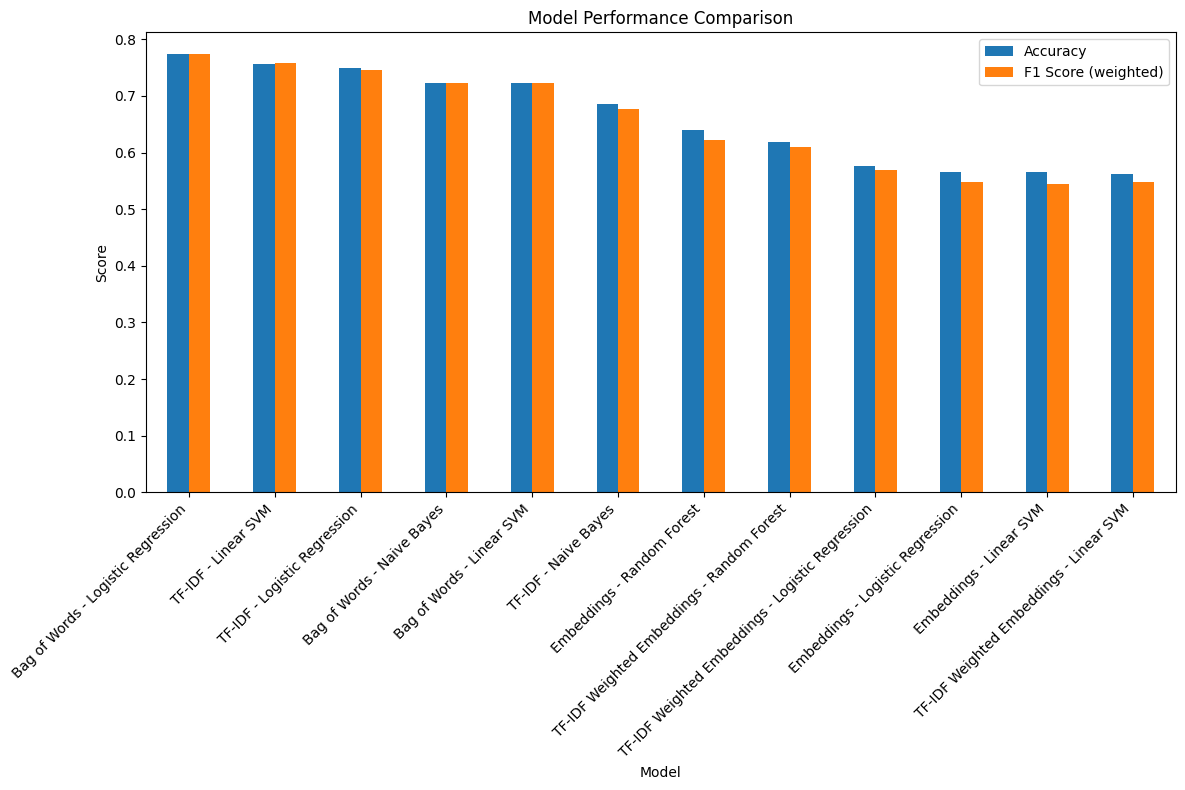


Best performing model: Bag of Words - Logistic Regression
Accuracy: 0.7733
F1 Score: 0.7737


In [ ]:
# Define target variable - only sentiment
y_sentiment = labels_df['sentiment']

# Split data for each feature type
X_tfidf_train, X_tfidf_test, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y_sentiment, test_size=0.2, random_state=420, stratify=y_sentiment
)

X_bow_train, X_bow_test, y_train_bow, y_test_bow = train_test_split(
    X_bow, y_sentiment, test_size=0.2, random_state=420, stratify=y_sentiment
)

X_emb_train, X_emb_test, y_train_emb, y_test_emb = train_test_split(
    X_embeddings, y_sentiment, test_size=0.2, random_state=420, stratify=y_sentiment
)

X_tfidf_emb_train, X_tfidf_emb_test, y_train_tfidf_emb, y_test_tfidf_emb = train_test_split(
    X_tfidf_embeddings, y_sentiment, test_size=0.2, random_state=420, stratify=y_sentiment
)

# Define models for sparse matrix features (TF-IDF and BoW)
sparse_models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
    'Linear SVM': LinearSVC(C=1.0, max_iter=10000)
}

# Define models for dense matrix features (embeddings)
dense_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Linear SVM': LinearSVC(C=1.0, max_iter=10000)
}

# Function to evaluate models and display results
def evaluate_models(X_train, X_test, y_train, y_test, models, feature_name):
    results = {}
    print(f"\n----- Sentiment Classification Results ({feature_name}) -----")
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Store model performance
        report = classification_report(y_test, y_pred, output_dict=True)
        results[name] = {
            'accuracy': report['accuracy'],
            'weighted_f1': report['weighted avg']['f1-score'],
            'model': model
        }
        
        # Print classification report
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=sorted(y_sentiment.unique()),
                   yticklabels=sorted(y_sentiment.unique()))
        plt.title(f'Confusion Matrix - {name} ({feature_name})')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Show top misclassifications
        wrong_indices = np.where(y_test != y_pred)[0]
        if len(wrong_indices) > 0:
            print("\nTop misclassifications:")
            for idx in wrong_indices[:5]:  # Show first 5 misclassifications
                print(f"True: {y_test.iloc[idx]}, Predicted: {y_pred[idx]}")
    
    return results

# Evaluate all feature types
tfidf_results = evaluate_models(X_tfidf_train, X_tfidf_test, y_train_tfidf, y_test_tfidf, sparse_models, "TF-IDF")
bow_results = evaluate_models(X_bow_train, X_bow_test, y_train_bow, y_test_bow, sparse_models, "Bag of Words")
emb_results = evaluate_models(X_emb_train, X_emb_test, y_train_emb, y_test_emb, dense_models, "Embeddings")
tfidf_emb_results = evaluate_models(X_tfidf_emb_train, X_tfidf_emb_test, y_train_tfidf_emb, y_test_tfidf_emb, dense_models, "TF-IDF Weighted Embeddings")

# Combine all results for comparison
all_results = {}
for feature_name, results in zip(
    ["TF-IDF", "Bag of Words", "Embeddings", "TF-IDF Weighted Embeddings"],
    [tfidf_results, bow_results, emb_results, tfidf_emb_results]
):
    for model_name, metrics in results.items():
        key = f"{feature_name} - {model_name}"
        all_results[key] = metrics

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': [k for k in all_results.keys()],
    'Accuracy': [v['accuracy'] for v in all_results.values()],
    'F1 Score (weighted)': [v['weighted_f1'] for v in all_results.values()]
})

# Sort by accuracy
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

# Display and save comparison results
print("\n----- Overall Model Comparison -----")
print(comparison_df)
comparison_df.to_csv('sentiment_model_comparison.csv', index=False)

# Plot comparison bar chart
plt.figure(figsize=(12, 8))
comparison_df.plot(x='Model', y=['Accuracy', 'F1 Score (weighted)'], kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('sentiment_model_comparison.png')
plt.show()

# Find the best model
best_model_row = comparison_df.iloc[0]
best_model_name = best_model_row['Model']
print(f"\nBest performing model: {best_model_name}")
print(f"Accuracy: {best_model_row['Accuracy']:.4f}")
print(f"F1 Score: {best_model_row['F1 Score (weighted)']:.4f}")


--- Initial datasets ---
TF-IDF Training set class distribution: Counter({'Mixed': 521, 'Positive': 477, 'Negative': 430, 'Neutral': 71})
BoW Training set class distribution: Counter({'Mixed': 521, 'Positive': 477, 'Negative': 430, 'Neutral': 71})

--- After SMOTE ---
TF-IDF Training set class distribution after SMOTE: Counter({'Positive': 521, 'Negative': 521, 'Mixed': 521, 'Neutral': 521})
BoW Training set class distribution after SMOTE: Counter({'Positive': 521, 'Negative': 521, 'Mixed': 521, 'Neutral': 521})

=== SCENARIO 1: Original training data → Original test data ===

--- Training TF-IDF - Linear SVM on Original→Original data ---
Classification Report for TF-IDF - Linear SVM on Original→Original data:
              precision    recall  f1-score   support

       Mixed       0.73      0.75      0.74       131
    Negative       0.79      0.83      0.81       107
     Neutral       1.00      0.67      0.80        18
    Positive       0.86      0.84      0.85       119

    acc

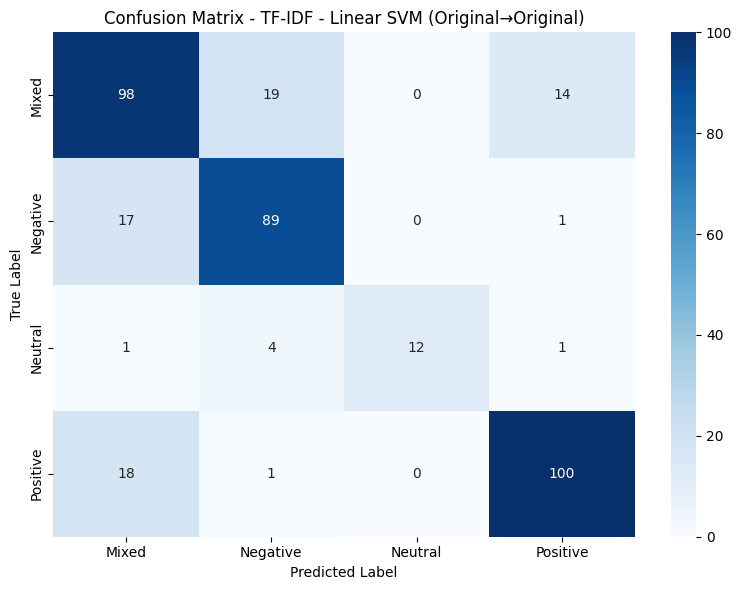


--- Training BoW - Logistic Regression on Original→Original data ---
Classification Report for BoW - Logistic Regression on Original→Original data:
              precision    recall  f1-score   support

       Mixed       0.71      0.73      0.72       131
    Negative       0.76      0.81      0.78       107
     Neutral       0.92      0.61      0.73        18
    Positive       0.82      0.78      0.80       119

    accuracy                           0.77       375
   macro avg       0.80      0.73      0.76       375
weighted avg       0.77      0.77      0.77       375



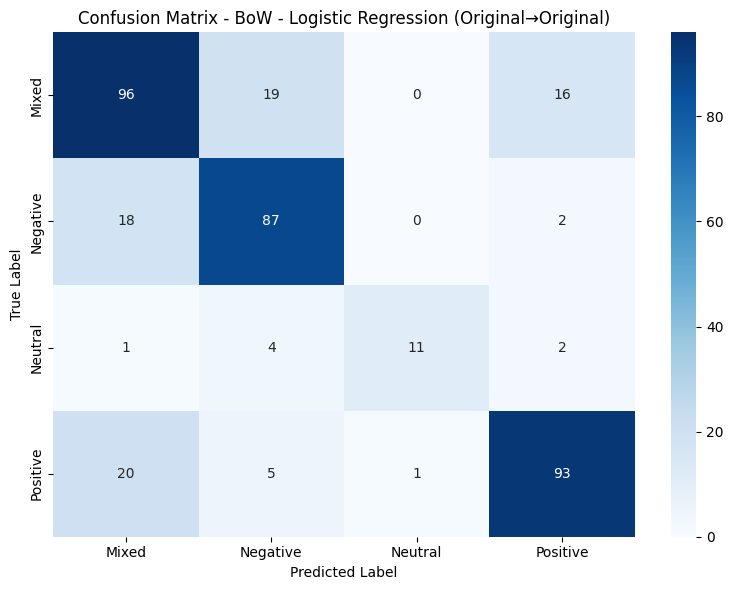


=== SCENARIO 2: SMOTE training data → Original test data ===

--- Training TF-IDF - Linear SVM on SMOTE→Original data ---
Classification Report for TF-IDF - Linear SVM on SMOTE→Original data:
              precision    recall  f1-score   support

       Mixed       0.73      0.73      0.73       131
    Negative       0.77      0.83      0.80       107
     Neutral       0.86      0.67      0.75        18
    Positive       0.84      0.82      0.83       119

    accuracy                           0.78       375
   macro avg       0.80      0.76      0.78       375
weighted avg       0.79      0.78      0.78       375



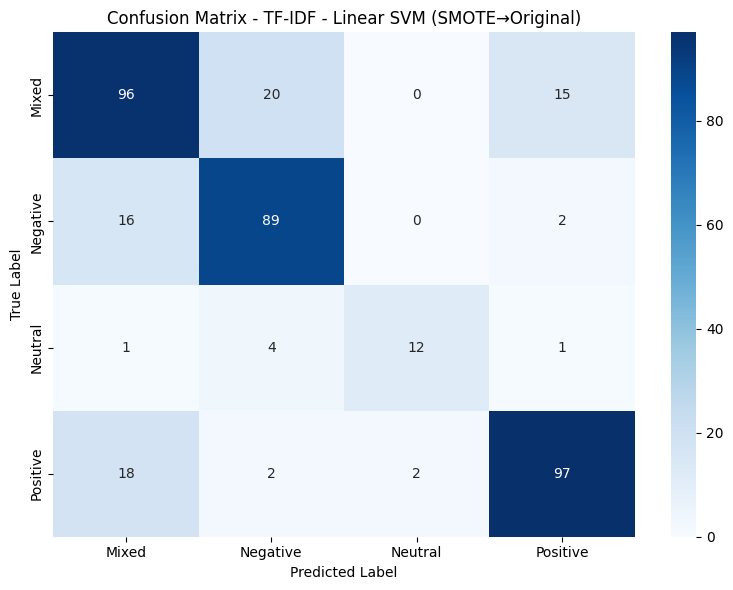


--- Training BoW - Logistic Regression on SMOTE→Original data ---
Classification Report for BoW - Logistic Regression on SMOTE→Original data:
              precision    recall  f1-score   support

       Mixed       0.75      0.70      0.73       131
    Negative       0.75      0.83      0.79       107
     Neutral       0.68      0.72      0.70        18
    Positive       0.82      0.80      0.81       119

    accuracy                           0.77       375
   macro avg       0.75      0.76      0.76       375
weighted avg       0.77      0.77      0.77       375



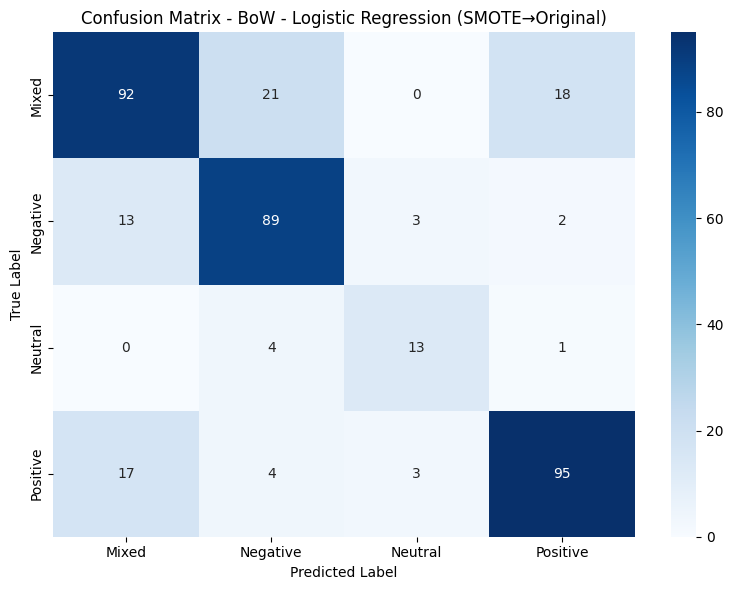


----- Overall Model Comparison -----
                       model           scenario  accuracy  weighted_f1
0        TF-IDF - Linear SVM  Original→Original  0.797333     0.797706
2        TF-IDF - Linear SVM     SMOTE→Original  0.784000     0.783869
3  BoW - Logistic Regression     SMOTE→Original  0.770667     0.770088
1  BoW - Logistic Regression  Original→Original  0.765333     0.765404


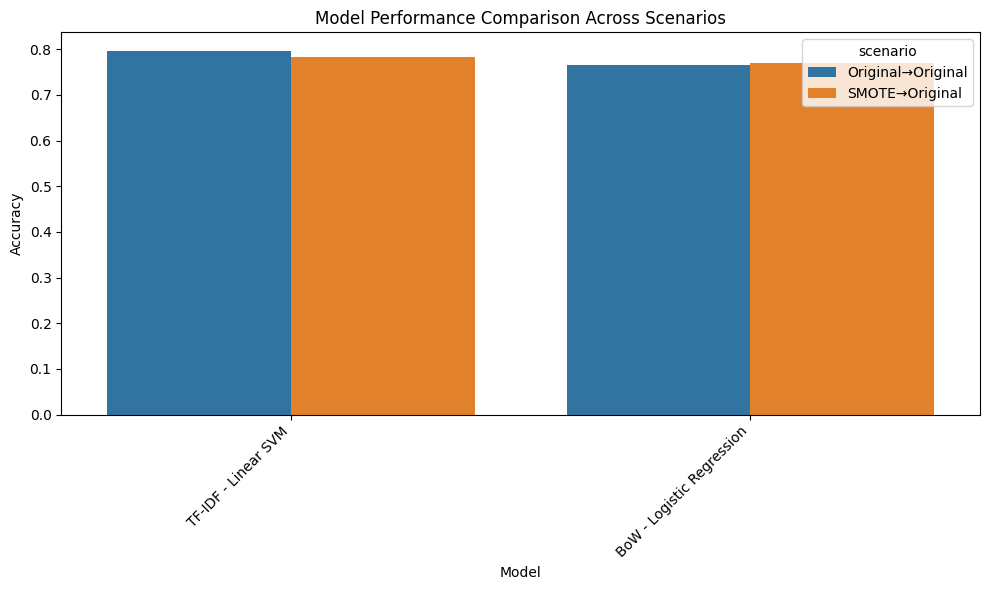


Best performing model: TF-IDF - Linear SVM (Original→Original)
Accuracy: 0.7973
F1 Score: 0.7977


In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import load_npz, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load your features and label

# Define target variable - only sentiment
y_sentiment = labels_df['sentiment']

# First, split into train and test sets (80/20)
X_tfidf_train, X_tfidf_test, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y_sentiment, test_size=0.2, random_state=42, stratify=y_sentiment
)

X_bow_train, X_bow_test, y_train_bow, y_test_bow = train_test_split(
    X_bow, y_sentiment, test_size=0.2, random_state=42, stratify=y_sentiment
)

print("\n--- Initial datasets ---")
print("TF-IDF Training set class distribution:", Counter(y_train_tfidf))
print("BoW Training set class distribution:", Counter(y_train_bow))

# Convert to dense format for SMOTE
X_tfidf_train_dense = X_tfidf_train.toarray()
X_bow_train_dense = X_bow_train.toarray()

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)

X_tfidf_train_smote, y_train_tfidf_smote = smote.fit_resample(X_tfidf_train_dense, y_train_tfidf)
X_bow_train_smote, y_train_bow_smote = smote.fit_resample(X_bow_train_dense, y_train_bow)

print("\n--- After SMOTE ---")
print("TF-IDF Training set class distribution after SMOTE:", Counter(y_train_tfidf_smote))
print("BoW Training set class distribution after SMOTE:", Counter(y_train_bow_smote))

# Convert back to sparse matrices for compatibility
X_tfidf_train_smote_sparse = csr_matrix(X_tfidf_train_smote)
X_bow_train_smote_sparse = csr_matrix(X_bow_train_smote)

# Define models
models = {
    'TF-IDF - Linear SVM': LinearSVC(C=1.0, max_iter=10000),
    'BoW - Logistic Regression': LogisticRegression(max_iter=1000, C=1.0)
}

# Function to evaluate models and display results
def evaluate_model(name, model, X_train, y_train, X_test, y_test, test_type):
    print(f"\n--- Training {name} on {test_type} data ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report['accuracy']
    weighted_f1 = report['weighted avg']['f1-score']
    
    # Print classification report
    print(f"Classification Report for {name} on {test_type} data:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=sorted(np.unique(y_test)),
               yticklabels=sorted(np.unique(y_test)))
    plt.title(f'Confusion Matrix - {name} ({test_type})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_")}_{test_type}.png')
    plt.show()
    
    return {
        'model': name,
        'scenario': test_type,
        'accuracy': accuracy,
        'weighted_f1': weighted_f1
    }

# Run different training and testing scenarios
results = []

# Scenario 1: Original training data → Original test data
print("\n=== SCENARIO 1: Original training data → Original test data ===")
results.append(evaluate_model('TF-IDF - Linear SVM', models['TF-IDF - Linear SVM'],
                              X_tfidf_train, y_train_tfidf, X_tfidf_test, y_test_tfidf, "Original→Original"))

results.append(evaluate_model('BoW - Logistic Regression', models['BoW - Logistic Regression'],
                              X_bow_train, y_train_bow, X_bow_test, y_test_bow, "Original→Original"))

# Scenario 2: SMOTE training data → Original test data
print("\n=== SCENARIO 2: SMOTE training data → Original test data ===")
results.append(evaluate_model('TF-IDF - Linear SVM', models['TF-IDF - Linear SVM'],
                              X_tfidf_train_smote_sparse, y_train_tfidf_smote, X_tfidf_test, y_test_tfidf, "SMOTE→Original"))

results.append(evaluate_model('BoW - Logistic Regression', models['BoW - Logistic Regression'],
                              X_bow_train_smote_sparse, y_train_bow_smote, X_bow_test, y_test_bow, "SMOTE→Original"))

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)

# Sort by accuracy
comparison_df = comparison_df.sort_values('accuracy', ascending=False)

# Display and save comparison results
print("\n----- Overall Model Comparison -----")
print(comparison_df)
comparison_df.to_csv('sentiment_model_comparison_selected_scenarios.csv', index=False)

# Plot comparison of all scenarios
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='accuracy', hue='scenario', data=comparison_df)
plt.title('Model Performance Comparison Across Scenarios')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('model_comparison_selected_scenarios.png')
plt.show()

# Find the best model
best_model_row = comparison_df.iloc[0]
print(f"\nBest performing model: {best_model_row['model']} ({best_model_row['scenario']})")
print(f"Accuracy: {best_model_row['accuracy']:.4f}")
print(f"F1 Score: {best_model_row['weighted_f1']:.4f}")



----- Cross-Validation Results for TF-IDF + Linear SVM -----
   accuracy_mean  accuracy_std   f1_mean    f1_std
0       0.768934       0.02108  0.767618  0.022927


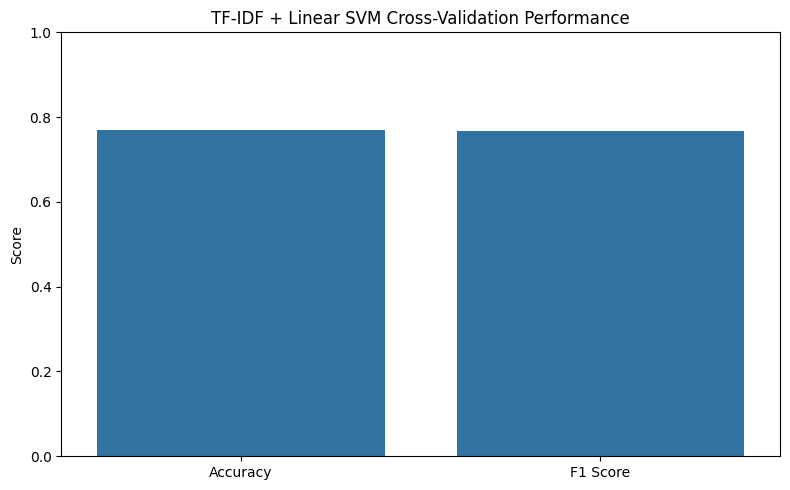


TF-IDF + Linear SVM:
Mean Accuracy: 0.7689 ± 0.0211
Mean F1 Score: 0.7676 ± 0.0229


In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score

# Define target variable - only sentiment
y_sentiment = labels_df['sentiment']

# Define model
model = LinearSVC(C=1.0, max_iter=10000)

# Define cross-validation strategy (5-Fold Stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Custom scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'weighted_f1': make_scorer(f1_score, average='weighted')
}

# Perform cross-validation
accuracy_scores = cross_val_score(model, X_tfidf, y_sentiment, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(model, X_tfidf, y_sentiment, cv=cv, scoring='f1_weighted')
# Store results
results = {
    'accuracy_mean': np.mean(accuracy_scores),
    'accuracy_std': np.std(accuracy_scores),
    'f1_mean': np.mean(f1_scores),
    'f1_std': np.std(f1_scores)
}

# Convert results to DataFrame for easy visualization
comparison_df = pd.DataFrame([results])

# Display and save comparison results
print("\n----- Cross-Validation Results for TF-IDF + Linear SVM -----")
print(comparison_df)
comparison_df.to_csv('tfidf_svm_crossval_results.csv', index=False)

# Plot accuracy distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=['Accuracy', 'F1 Score'], y=[results['accuracy_mean'], results['f1_mean']])
plt.title('TF-IDF + Linear SVM Cross-Validation Performance')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('tfidf_svm_crossval_performance.png')
plt.show()

# Print final model performance
print(f"\nTF-IDF + Linear SVM:")
print(f"Mean Accuracy: {results['accuracy_mean']:.4f} ± {results['accuracy_std']:.4f}")
print(f"Mean F1 Score: {results['f1_mean']:.4f} ± {results['f1_std']:.4f}")


Starting hyperparameter tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

----- Hyperparameter Tuning Results -----
Best Parameters: {'C': 1.2, 'class_weight': None, 'dual': True, 'loss': 'hinge', 'tol': 5e-05}
Best F1 Score: 0.7790

Top 5 Parameter Combinations:
                                               params  mean_test_score  \
60  {'C': 1.1, 'class_weight': None, 'dual': True,...         0.778406   
61  {'C': 1.1, 'class_weight': None, 'dual': True,...         0.778406   
62  {'C': 1.1, 'class_weight': None, 'dual': True,...         0.778406   
72  {'C': 1.2, 'class_weight': None, 'dual': True,...         0.778997   
73  {'C': 1.2, 'class_weight': None, 'dual': True,...         0.778997   
74  {'C': 1.2, 'class_weight': None, 'dual': True,...         0.778997   

    std_test_score  rank_test_score  
60        0.018787                4  
61        0.018787                4  
62        0.018787                4  
72        0.020569                1  
73 

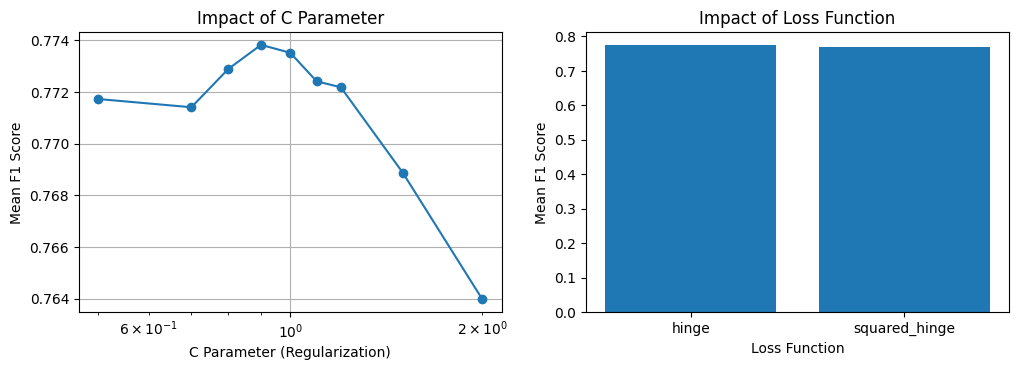

In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Define target variable - only sentiment
y_sentiment = labels_df['sentiment']
X_tfidf = load_npz(os.path.join(features_dir, 'tfidf_features.npz'))

# Define cross-validation strategy (5-Fold Stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0],  # More dense around 1.0
    'loss': ['hinge', 'squared_hinge'],
    'dual': [True],  # Since False causes issues with hinge loss
    'tol': [0.00005, 0.0001, 0.0005],  # More precise tolerance values
    'class_weight': [None, 'balanced']
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=LinearSVC(max_iter=10000),
    param_grid=param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,  # Use all available cores
    verbose=2   # Detailed output
)

# Fit the grid search to find the best hyperparameters
print("Starting hyperparameter tuning...")
grid_search.fit(X_tfidf, y_sentiment)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train final model with best parameters
best_model = LinearSVC(**best_params, max_iter=10000)
best_model.fit(X_tfidf, y_sentiment)


# Print results
print("\n----- Hyperparameter Tuning Results -----")
print(f"Best Parameters: {best_params}")
print(f"Best F1 Score: {best_score:.4f}")

# Create and display a results DataFrame 
cv_results = pd.DataFrame(grid_search.cv_results_)
best_idx = cv_results['rank_test_score'] == 1
display_cols = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
print("\nTop 5 Parameter Combinations:")
print(cv_results.loc[cv_results['rank_test_score'] <= 5, display_cols])

# Save the best parameters
pd.DataFrame([best_params]).to_csv('best_svm_params.csv', index=False)

# Visualize hyperparameter impact
plt.figure(figsize=(12, 8))

# Plot the impact of C parameter (most important for SVM)
c_values = sorted(list(param_grid['C']))
c_scores = []

for c in c_values:
    mask = cv_results['param_C'] == c
    c_scores.append(cv_results.loc[mask, 'mean_test_score'].mean())

plt.subplot(2, 2, 1)
plt.semilogx(c_values, c_scores, marker='o')
plt.xlabel('C Parameter (Regularization)')
plt.ylabel('Mean F1 Score')
plt.title('Impact of C Parameter')
plt.grid(True)

# Compare Loss Functions
loss_scores = []
for loss in param_grid['loss']:
    mask = cv_results['param_loss'] == loss
    loss_scores.append(cv_results.loc[mask, 'mean_test_score'].mean())

plt.subplot(2, 2, 2)
plt.bar(param_grid['loss'], loss_scores)
plt.xlabel('Loss Function')
plt.ylabel('Mean F1 Score')
plt.title('Impact of Loss Function')

# Save the best model
import joblib
joblib.dump(best_model, 'best_svm_model.joblib')

print("\nBest model saved as 'best_svm_model.joblib'")
print("Hyperparameter impact visualization saved as 'hyperparameter_impact.png'")



Let's test our super model


Final model trained correctly and saved as 'best_svm_model_fixed.joblib'

Corrected Final Test Set Performance:
              precision    recall  f1-score   support

       Mixed       0.72      0.72      0.72       131
    Negative       0.76      0.81      0.79       107
     Neutral       1.00      0.61      0.76        18
    Positive       0.82      0.82      0.82       119

    accuracy                           0.77       375
   macro avg       0.83      0.74      0.77       375
weighted avg       0.78      0.77      0.77       375



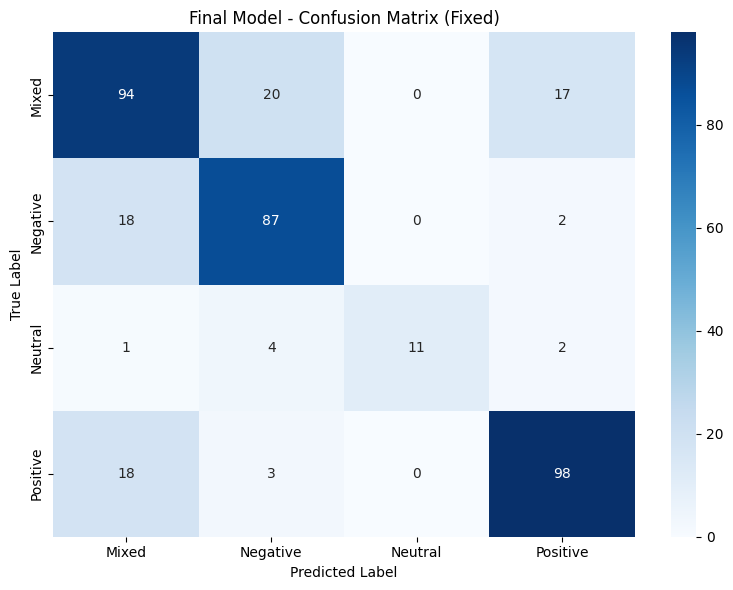

In [48]:
import os
import numpy as np
import pandas as pd
import joblib
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 🚀 Load Data Again
features_dir = 'features'
X_tfidf = load_npz(os.path.join(features_dir, 'tfidf_features.npz'))
y_sentiment = labels_df['sentiment']

# 🚀 Proper Train-Test Split (No Leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_sentiment, test_size=0.2, random_state=42, stratify=y_sentiment
)

# 🚀 Load the Best Grid Search Parameters

# 🚀 Retrain the Final Model on Train Data Only
best_model = LinearSVC(**best_params, max_iter=10000)
best_model.fit(X_train, y_train)  # ✅ No test data in training!

# 🚀 Save the Correctly Trained Model
joblib.dump(best_model, 'best_svm_model_fixed.joblib')
print("\nFinal model trained correctly and saved as 'best_svm_model_fixed.joblib'")

# 🚀 Evaluate Again on the Unseen Test Set
y_test_pred = best_model.predict(X_test)

print("\nCorrected Final Test Set Performance:")
print(classification_report(y_test, y_test_pred))

# 🚀 Generate and Save Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.title('Final Model - Confusion Matrix (Fixed)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('final_confusion_matrix_fixed.png')
plt.show()


In [38]:
best_model = joblib.load('best_svm_model.joblib')
